# Assignment 2: Deep Q Learning and Policy Gradient

-----

*2022-2023 fall quarter, CS269 Seminar 5: Reinforcement Learning. Department of Computer Science at University of California, Los Angeles. Course Instructor: Professor Bolei ZHOU. Assignment author: Zhenghao PENG.*



| Student Name | Student ID |
| :----: | :----: |
| TYPE_YOUR_NAME_HERE | TYPE_YOUR_STUDENT_ID_HERE |

------

Welcome to the assignment 2 of our RL course. This assignment consists of three parts:

* Section 2: Implement Q learning in tabular setting (20 points)
* Section 3: Implement Deep Q Network with pytorch (30 points)
* Section 4: Implement policy gradient method REINFORCE with pytorch (30 points)
* Section 5: Implement policy gradient method with baseline (20 points)

Section 0 and Section 1 set up the dependencies and prepare some useful functions.

The experiments we'll conduct and their expected goals:

1. Naive Q learning in FrozenLake &emsp; (should solve)
2. DQN in CartPole &emsp; (should solve)
3. DQN in MetaDrive-Easy &emsp; (should solve)
4. DQN in MetaDrive-Hard &emsp; (>50 return)
5. Policy Gradient w/o baseline in CartPole (w/ and w/o advantage normalization) &emsp; (should solve)
6. Policy Gradient w/o baseline in MetaDrive-Easy &emsp; (should solve)
7. Policy Gradient w/ baseline in CartPole (w/ advantage normalization) &emsp; (should solve)
8. Policy Gradient w/ baseline in MetaDrive-Easy &emsp; (should solve)
9. Policy Gradient w/ baseline in MetaDrive-Hard &emsp; (>50 return)

## Section 0: Dependencies

Please install the following dependencies.


### Notes on MetaDrive

MetaDrive is a lightweight driving simulator which we will use for DQN and Policy Gradient methods. It can not be run on M1-chip Mac. We suggest using Colab or Linux for running MetaDrive.

Please ignore this warning from MetaDrive: `WARNING:root:BaseEngine is not launched, fail to sync seed to engine!`

### Notes on Colab

We have several cells used for installing dependencies for Colab only. Please make sure they are run properly.

You don't need to install python packages again and again after **restarting the runtime**, since the Colab instance still remembers the python envionment after you installing packages for the first time. But you do need to rerun those packages installation script after you **reconnecting to the runtime** (which means Google assigns a new machine to you and thus the python environment is new).

In [ ]:
!pip install "gym[classic_control,box2d]<0.20.0" seaborn pandas
!pip install torch

In [ ]:
# Install MetaDrive, a lightweight driving simulator
!pip install git+https://github.com/metadriverse/metadrive

# Test whether MetaDrive is properly installed. No error means the test is passed.
!python -m metadrive.examples.profile_metadrive --num-steps 1000

In [ ]:
# If you are using Colab, please run the following script EACH time you disconnect from a Runtime.

!apt-get install -y xvfb python-opengl
!pip install pyvirtualdisplay

In [ ]:
# If you are using Colab, please run the following script EACH time you restart the Runtime.
import os
os.environ['SDL_VIDEODRIVER']='dummy'

from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

## Section 1: Building abstract class and helper functions

In [1]:
# Run this cell without modification

# Import some packages that we need to use
import gym
import numpy as np
import pandas as pd
import seaborn as sns
from collections import deque
import copy
from gym.error import Error
from gym import logger, error
import torch
import torch.nn as nn
import time
from IPython.display import clear_output
from gym.envs.registration import register
import copy
import json
import os
import subprocess
import tempfile
import time
import IPython
import PIL
import pygame


def wait(sleep=0.2):
    clear_output(wait=True)
    time.sleep(sleep)

    
def merge_config(new_config, old_config):
    """Merge the user-defined config with default config"""
    config = copy.deepcopy(old_config)
    if new_config is not None:
        config.update(new_config)
    return config



def test_random_policy(policy, env):
    _acts = set()
    for i in range(1000):
        act = policy(0)
        _acts.add(act)
        assert env.action_space.contains(act), "Out of the bound!"
    if len(_acts) != 1:
        print(
            "[HINT] Though we call self.policy 'random policy', " \
            "we find that generating action randomly at the beginning " \
            "and then fixing it during updating values period lead to better " \
            "performance. Using purely random policy is not even work! " \
            "We encourage you to investigate this issue."
        )
        

# We register a non-slippery version of FrozenLake environment.
try:
    register(
        id='FrozenLakeNotSlippery-v1',
        entry_point='gym.envs.toy_text:FrozenLakeEnv',
        kwargs={'map_name' : '4x4', 'is_slippery': False},
        max_episode_steps=200,
        reward_threshold=0.78, # optimum = .8196
    )
except Error:
    print("The environment is registered already.")

    
def _render_helper(env, mode, sleep=0.1):
    ret = env.render(mode)
    if sleep:
        wait(sleep=sleep)
    return ret
    
    
def animate(img_array):
    """A function that can generate GIF file and show in Notebook."""
    path = tempfile.mkstemp(suffix=".gif")[1]
    images = [PIL.Image.fromarray(frame) for frame in img_array]
    images[0].save(
        path,
        save_all=True,
        append_images=images[1:],
        duration=0.05,
        loop=0
    )
    with open(path, "rb") as f:
        IPython.display.display(
            IPython.display.Image(data=f.read(), format='png'))


def evaluate(policy, num_episodes=1, seed=0, env_name='FrozenLake8x8-v1',
             render=None, existing_env=None, max_episode_length=1000,
             sleep=0.0, verbose=False):
    """This function evaluate the given policy and return the mean episode 
    reward.
    :param policy: a function whose input is the observation
    :param num_episodes: number of episodes you wish to run
    :param seed: the random seed
    :param env_name: the name of the environment
    :param render: a boolean flag indicating whether to render policy
    :return: the averaged episode reward of the given policy.
    """
    if existing_env is None:
        env = gym.make(env_name)
        env.seed(seed)
    else:
        env = existing_env
    rewards = []
    frames = []
    if render: num_episodes = 1
    for i in range(num_episodes):
        obs = env.reset()
        act = policy(obs)
        ep_reward = 0
        for step_count in range(max_episode_length):
            obs, reward, done, info = env.step(act)
            act = policy(obs)
            ep_reward += reward

            if verbose and step_count % 50 == 0:
                print("Evaluating {}/{} episodes. We are in {}/{} steps. Current episode reward: {:.3f}".format(
                    i + 1, num_episodes, step_count + 1, max_episode_length, ep_reward
                ))

            if render:
                frames.append(_render_helper(env, render, sleep))
                wait(sleep=0.05)
            if done:
                break
        rewards.append(ep_reward)
    if render:
        env.close()
    return np.mean(rewards), {"frames": frames}


pygame 2.1.2 (SDL 2.0.16, Python 3.7.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Run this cell without modification

DEFAULT_CONFIG = dict(
    seed=0,
    max_iteration=20000,
    max_episode_length=200,
    evaluate_interval=10,
    evaluate_num_episodes=10,
    learning_rate=0.01,
    gamma=0.8,
    eps=0.3,
    env_name='FrozenLakeNotSlippery-v1'
)

class AbstractTrainer:
    """This is the abstract class for value-based RL trainer. We will inherent
    the specify algorithm's trainer from this abstract class, so that we can
    reuse the codes.
    """

    def __init__(self, config):
        self.config = merge_config(config, DEFAULT_CONFIG)

        # Create the environment
        self.env_name = self.config['env_name']
        self.env = gym.make(self.env_name)

        # Apply the random seed
        self.seed = self.config["seed"]
        np.random.seed(self.seed)
        self.env.seed(self.seed)

        # We set self.obs_dim to the number of possible observation
        # if observation space is discrete, otherwise the number
        # of observation's dimensions. The same to self.act_dim.
        if isinstance(self.env.observation_space, gym.spaces.box.Box):
            assert len(self.env.observation_space.shape) == 1
            self.obs_dim = self.env.observation_space.shape[0]
            self.discrete_obs = False
        elif isinstance(self.env.observation_space,
                        gym.spaces.discrete.Discrete):
            self.obs_dim = self.env.observation_space.n
            self.discrete_obs = True
        else:
            raise ValueError("Wrong observation space!")

        if isinstance(self.env.action_space, gym.spaces.box.Box):
            assert len(self.env.action_space.shape) == 1
            self.act_dim = self.env.action_space.shape[0]
        elif isinstance(self.env.action_space, gym.spaces.discrete.Discrete):
            self.act_dim = self.env.action_space.n
        elif isinstance(self.env.action_space, gym.spaces.MultiDiscrete):
            MetaDrive-Tut-Easy-v0
        else:
            raise ValueError("Wrong action space! {}".format(self.env.action_space))

        self.eps = self.config['eps']


    def process_state(self, state):
        """
        Process the raw observation. For example, we can use this function to
        convert the input state (integer) to a one-hot vector.
        """
        return state

    def compute_action(self, processed_state, eps=None):
        """Compute the action given the processed state."""
        raise NotImplementedError(
            "You need to override the Trainer.compute_action() function.")

    def evaluate(self, num_episodes=50, *args, **kwargs):
        """Use the function you write to evaluate current policy.
        Return the mean episode reward of 50 episodes."""
        if "MetaDrive" in self.env_name:
            kwargs["existing_env"] = self.env
        result, eval_infos = evaluate(self.policy, num_episodes, seed=self.seed,
                          env_name=self.env_name, *args, **kwargs)
        return result, eval_infos

    def policy(self, raw_state, eps=0.0):
        """A wrapper function takes raw_state as input and output action."""
        return self.compute_action(self.process_state(raw_state), eps=eps)
    
    def train(self):
        """Conduct one iteration of learning."""
        raise NotImplementedError("You need to override the "
                                  "Trainer.train() function.")


In [3]:
# Run this cell without modification

def run(trainer_cls, config=None, reward_threshold=None):
    """Run the trainer and report progress, agnostic to the class of trainer
    :param trainer_cls: A trainer class 
    :param config: A dict
    :param reward_threshold: the reward threshold to break the training
    :return: The trained trainer and a dataframe containing learning progress
    """
    if config is None:
        config = {}
    trainer = trainer_cls(config)
    config = trainer.config
    start = now = time.time()
    stats = []
    total_steps = 0
    
    try:
        for i in range(config['max_iteration'] + 1):
            stat = trainer.train()
            stat = stat or {}
            stats.append(stat)
            if "episode_len" in stat:
                total_steps += stat["episode_len"]
            if i % config['evaluate_interval'] == 0 or \
                    i == config["max_iteration"]:
                reward, _ = trainer.evaluate(
                    config.get("evaluate_num_episodes", 50), 
                    max_episode_length=config.get("max_episode_length", 1000)
                )
                print("({:.1f}s,+{:.1f}s) Iter {}, {}episodic return"
                      " is {:.2f}. {}".format(
                            time.time() - start, 
                            time.time() - now, 
                            i, 
                            "" if total_steps == 0 else "Step {}, ".format(total_steps),
                            reward,
                            {k: round(np.mean(v), 4) for k, v in stat.items() 
                            if not np.isnan(v) and k != "frames"
                            }
                                  if stat else ""
                      ))
                now = time.time()
            if reward_threshold is not None and reward > reward_threshold:
                print("In {} iteration, episodic return {:.3f} is "
                      "greater than reward threshold {}. Congratulation! Now we "
                      "exit the training process.".format(
                    i, reward, reward_threshold))
                break
    except Exception as e:
        print("Error happens during training: ")
        raise e
    finally:
        if hasattr(trainer.env, "close"):
            trainer.env.close()
            print("Environment is closed.")
                
    return trainer, stats


## Section 2: Q-Learning
(20/100 points)

Q-learning is an off-policy algorithm who differs from SARSA in the computing of TD error. 

Unlike getting the TD error by running policy to get `next_act` $a'$ and compute:

$r + \gamma Q(s', a') - Q(s, a)$

as in SARSA, in Q-learning we compute the TD error via:

$r + \gamma \max_{a'} Q(s', a') - Q(s, a)$. 

The reason we call it "off-policy" is that the next-Q value is not computed for the "behavior policy", instead, it is a "virtural policy" that always takes the best action given current Q values.

### Section 2.1: Building Q Learning Trainer

In [4]:
# Solve the TODOs and remove `pass`

# Managing configurations of your experiments is important for your research.
Q_LEARNING_TRAINER_CONFIG = merge_config(dict(
    eps=0.3,
), DEFAULT_CONFIG)


class QLearningTrainer(AbstractTrainer):
    def __init__(self, config=None):
        config = merge_config(config, Q_LEARNING_TRAINER_CONFIG)
        super(QLearningTrainer, self).__init__(config=config)
        self.gamma = self.config["gamma"]
        self.eps = self.config["eps"]
        self.max_episode_length = self.config["max_episode_length"]
        self.learning_rate = self.config["learning_rate"]

        # build the Q table
        self.table = np.zeros((self.obs_dim, self.act_dim))

    def compute_action(self, obs, eps=None):
        """Implement epsilon-greedy policy

        It is a function that take an integer (state / observation)
        as input and return an interger (action).
        """
        if eps is None:
            eps = self.eps

        # [TODO] You need to implement the epsilon-greedy policy here.
        pass
    
        return action

    def train(self):
        """Conduct one iteration of learning."""
        # [TODO] Q table may be need to be reset to zeros.
        # if you think it should, than do it. If not, then move on.
        pass

        obs = self.env.reset()
        for t in range(self.max_episode_length):
            act = self.compute_action(obs)

            next_obs, reward, done, _ = self.env.step(act)

            # [TODO] compute the TD error based on the next observation and current reward
            td_error = None
            pass

            # [TODO] compute the new Q value
            # hint: use TD error, self.learning_rate and current Q value
            new_value = None
            pass

            self.table[obs][act] = new_value
            obs = next_obs
            if done:
                break


### Section 2.2: Use Q Learning to train agent in FrozenLake

In [5]:
# Run this cell without modification

q_learning_trainer, _ = run(
    trainer_cls=QLearningTrainer,
    config=dict(
        max_iteration=5000,
        evaluate_interval=50,
        evaluate_num_episodes=50,
        env_name='FrozenLakeNotSlippery-v1'
    ),
    reward_threshold=0.99
)


(0.1s,+0.1s) Iter 0, episodic return is 0.00. 
(0.2s,+0.1s) Iter 50, episodic return is 0.00. 
(0.3s,+0.1s) Iter 100, episodic return is 0.00. 
(0.4s,+0.1s) Iter 150, episodic return is 0.00. 
(0.5s,+0.1s) Iter 200, episodic return is 0.00. 
(0.6s,+0.1s) Iter 250, episodic return is 0.00. 
(0.7s,+0.1s) Iter 300, episodic return is 0.00. 
(0.8s,+0.1s) Iter 350, episodic return is 0.00. 
(0.9s,+0.1s) Iter 400, episodic return is 0.00. 
(1.0s,+0.1s) Iter 450, episodic return is 0.00. 
(1.2s,+0.1s) Iter 500, episodic return is 0.00. 
(1.3s,+0.1s) Iter 550, episodic return is 0.00. 
(1.4s,+0.1s) Iter 600, episodic return is 0.00. 
(1.5s,+0.1s) Iter 650, episodic return is 0.00. 
(1.6s,+0.1s) Iter 700, episodic return is 0.00. 
(1.8s,+0.1s) Iter 750, episodic return is 0.00. 
(1.9s,+0.1s) Iter 800, episodic return is 0.00. 
(2.0s,+0.1s) Iter 850, episodic return is 0.00. 
(2.1s,+0.1s) Iter 900, episodic return is 0.00. 
(2.2s,+0.1s) Iter 950, episodic return is 0.00. 
(2.3s,+0.1s) Iter 1000,

In [6]:
# Run this cell without modification

# Render the learned behavior
_ = evaluate(
    policy=q_learning_trainer.policy, 
    num_episodes=1, 
    env_name=q_learning_trainer.env_name,
    render="human",  # Visualize the behavior here in the cell 
    sleep=0.5  # The time interval between two rendering frames
)


## Section 3: Implement Deep Q Learning in Pytorch

(30 / 100 points)

In this section, we will implement a basic neural network and Deep Q Learning with Pytorch, a powerful deep learning framework. 
Before start, you need to make sure using `pip install torch` to install it (see Section 0).

If you are not familiar with Pytorch, we suggest you to go through pytorch official quickstart tutorials:
1. [quickstart](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
2. [tutorial on RL](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)

Different from the Q learning in Section 2, we will implement Deep Q Network (DQN) in this section. The main differences are summarized as follows:

**DQN requires an experience replay memory to store the transitions.** A replay memory is implemented in the following `ExperienceReplayMemory` class. It contains a certain amount of transitions: `(s_t, a_t, r_t, s_t+1, done_t)`. When the memory is full, the earliest transition is discarded to store the latest one.

The introduction of replay memory increases the sample efficiency (since each transition might be used multiple times) when solving complex task. However, you may find it learn slowly in this assignment since the CartPole-v0 is a relatively easy environment.


**DQN has a delayed-updating target network.** DQN maintains another neural network called the target network that has identical structure of the Q network. After a certain amount of steps has been taken, the target network copies the parameters of the Q network to itself. Normally, the update of target network is much less frequent than the update of the Q network, since the Q network is updated in each step.

The reason to leverage the target network is to stabilize the estimation of the TD error. In DQN, the TD error is evaluated as:

$$(r_t + \gamma \max_{a_{t+1}} Q^{target}(s_{t+1}, a_{t+1}) - Q(s_t, a_t))$$

The Q value of the next state is estimated by the target network, not the Q network that is being updated. This mechanism can reduce the variance of gradient because the next Q values is not influenced by the update of current Q network.


### Section 3.1: Build DQN trainer

In [7]:
# Solve the TODOs and remove `pass`

from collections import deque
import random

class ExperienceReplayMemory:
    """Store and sample the transitions"""
    def __init__(self, capacity):
        # deque is a useful class which acts like a list but only contain
        # finite elements. When adding new element into the deque will make deque full with 
        # `maxlen` elements, the oldest element (the index 0 element) will be removed.
        
        # [TODO] uncomment next line. 
        # self.memory = deque(maxlen=capacity)
        pass

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [8]:
# Solve the TODOs and remove `pass`

class PytorchModel(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_units=100):
        super(PytorchModel, self).__init__()
        
        print("Num inputs: {}, Num actions: {}".format(num_inputs, num_actions))
        
        # [TODO] Build a nn.Sequential object as the neural network with two layers.
        # The first hidden layer has `hidden_units` hidden units, followed by
        # a ReLU activation function.
        # The second hidden layer takes `hidden_units`-dimensional vector as input
        # and output another `hidden_units`-dimensional vector, followed by ReLU activation.
        # The third layer take the activation vector from the second hidden layer, who has
        # `hidden_units` elements, as input and return `num_actions` values.
        self.action_value = None
        pass


    def forward(self, obs):
        return self.action_value(obs)
    
# Test
test_pytorch_model = PytorchModel(num_inputs=3, num_actions=7, hidden_units=123)
assert isinstance(test_pytorch_model.action_value, nn.Module)
assert len(test_pytorch_model.state_dict()) == 6
assert test_pytorch_model.state_dict()["action_value.0.weight"].shape == (123, 3)
print("Name of each parameter vectors: ", test_pytorch_model.state_dict().keys())

print("Test passed!")

Num inputs: 3, Num actions: 7
Name of each parameter vectors:  odict_keys(['action_value.0.weight', 'action_value.0.bias', 'action_value.2.weight', 'action_value.2.bias', 'action_value.4.weight', 'action_value.4.bias'])
Test passed!


In [9]:
# Solve the TODOs and remove `pass`

DQN_CONFIG = merge_config(dict(
    parameter_std=0.01,
    learning_rate=0.01,
    hidden_dim=100,
    clip_norm=1.0,
    clip_gradient=True,
    max_iteration=1000,
    max_episode_length=1000,
    evaluate_interval=100,
    gamma=0.99,
    eps=0.3,
    memory_size=50000,
    learn_start=5000,
    batch_size=32,
    target_update_freq=500,  # in steps
    learn_freq=1,  # in steps
    n=1,
    env_name="CartPole-v0",
), Q_LEARNING_TRAINER_CONFIG)


def to_tensor(x):
    """A helper function to transform a numpy array to a Pytorch Tensor"""
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x).type(torch.float32)
    assert isinstance(x, torch.Tensor)
    if x.dim() == 3 or x.dim() == 1:
        x = x.unsqueeze(0)
    assert x.dim() == 2 or x.dim() == 4, x.shape
    return x


class DQNTrainer(AbstractTrainer):
    def __init__(self, config):
        config = merge_config(config, DQN_CONFIG)
        self.learning_rate = config["learning_rate"]
        super().__init__(config)

        self.memory = ExperienceReplayMemory(config["memory_size"])
        
        self.learn_start = config["learn_start"]
        self.batch_size = config["batch_size"]
        self.target_update_freq = config["target_update_freq"]
        self.clip_norm = config["clip_norm"]
        self.hidden_dim = config["hidden_dim"]
        self.max_episode_length = self.config["max_episode_length"]
        self.learning_rate = self.config["learning_rate"]
        self.gamma = self.config["gamma"]
        self.n = self.config["n"]

        
        self.step_since_update = 0
        self.total_step = 0
        
        # You need to setup the parameter for your function approximator.
        self.initialize_parameters()

    def initialize_parameters(self):
        self.network = None
        print("Setting up self.network with obs dim: {} and action dim: {}".format(self.obs_dim, self.act_dim))
        self.network = PytorchModel(self.obs_dim, self.act_dim)

        self.network.eval()
        self.network.share_memory()

        # [TODO] Uncomment next few lines
        # Initialize target network, which is identical to self.network,
        # and should have the same weights with self.network. So you should
        # put the weights of self.network into self.target_network.
        
        # self.target_network = PytorchModel(self.obs_dim, self.act_dim)
        # self.target_network.load_state_dict(self.network.state_dict())
        pass

        self.target_network.eval()

        # Build Adam optimizer and MSE Loss.
        # [TODO] Uncomment next few lines
        # self.optimizer = torch.optim.Adam(
        #     self.network.parameters(), lr=self.learning_rate
        # )
        # self.loss = nn.MSELoss()
        pass
        
    def process_state(self, state):
        """Preprocess the state (observation).

        If the environment provides discrete observation (state), transform
        it to one-hot form. For example, the environment FrozenLake-v0
        provides an integer in [0, ..., 15] denotes the 16 possible states.
        We transform it to one-hot style:

        original state 0 -> one-hot vector [1, 0, 0, 0, 0, 0, 0, 0, ...]
        original state 1 -> one-hot vector [0, 1, 0, 0, 0, 0, 0, 0, ...]
        original state 15 -> one-hot vector [0, ..., 0, 0, 0, 0, 0, 1]

        If the observation space is continuous, then you should do nothing.
        """
        if not self.discrete_obs:
            return state
        else:
            new_state = np.zeros((self.obs_dim,))
            new_state[state] = 1
        return new_state
    
    def compute_values(self, processed_state):
        """Compute the value for each potential action. Note that you
        should NOT preprocess the state here."""
        values = self.network(processed_state).detach().numpy()
        return values
        
    def compute_action(self, processed_state, eps=None):
        """Compute the action given the state. Note that the input
        is the processed state."""

        values = self.compute_values(processed_state)
        assert values.ndim == 1, values.shape

        if eps is None:
            eps = self.eps

        if np.random.uniform(0, 1) < eps:
            action = self.env.action_space.sample()
        else:
            action = np.argmax(values)
        return action

    def train(self):
        s = self.env.reset()
        processed_s = self.process_state(s)
        act = self.compute_action(processed_s)
        stat = {"loss": [], "success_rate": np.nan}

        for t in range(self.max_episode_length):
            next_state, reward, done, info = self.env.step(act)
            next_processed_s = self.process_state(next_state)

            # Push the transition into memory.
            self.memory.push(
                (processed_s, act, reward, next_processed_s, done)
            )

            processed_s = next_processed_s
            act = self.compute_action(next_processed_s)
            self.step_since_update += 1
            self.total_step += 1

            if done:
                # print("INFO: ", info)
                if "arrive_dest" in info:
                    stat["success_rate"] = info["arrive_dest"]
                break
                
            if t % self.config["learn_freq"] != 0:
                # It's not necessary to update in each step.
                continue

            if len(self.memory) < self.learn_start:
                continue
            elif len(self.memory) == self.learn_start:
                print("Current memory contains {} transitions, "
                      "start learning!".format(self.learn_start))

            batch = self.memory.sample(self.batch_size)

            # Transform a batch of state / action / .. into a tensor.
            state_batch = to_tensor(
                np.stack([transition[0] for transition in batch])
            )
            action_batch = to_tensor(
                np.stack([transition[1] for transition in batch])
            )
            reward_batch = to_tensor(
                np.stack([transition[2] for transition in batch])
            )
            next_state_batch = torch.stack(
                [transition[3] for transition in batch]
            )
            done_batch = to_tensor(
                np.stack([transition[4] for transition in batch])
            )

            with torch.no_grad():
                # [TODO] Compute the Q values of next states
                Q_t_plus_one = None
                pass
                
                assert isinstance(Q_t_plus_one, torch.Tensor)
                assert Q_t_plus_one.dim() == 1
                
                # [TODO] Compute the target value of Q
                Q_target = None
                pass
                
                assert Q_target.shape == (self.batch_size,)
            
            # Collect the Q values in batch.
            self.network.train()
            q_out = self.network(state_batch)
            assert q_out.dim() == 2
            Q_t = q_out.gather(1, action_batch.long().view(-1, 1)).squeeze(-1)
    
            assert Q_t.shape == Q_target.shape

            # Update the network
            self.optimizer.zero_grad()
            loss = self.loss(input=Q_t, target=Q_target)
            loss_value = loss.item()
            stat['loss'].append(loss_value)
            loss.backward()
            
            # [TODO] Gradient clipping. Uncomment next line
            # nn.utils.clip_grad_norm_(self.network.parameters(), self.clip_norm)
            pass
            
            self.optimizer.step()
            self.network.eval()

        if len(self.memory) >= self.learn_start and \
                self.step_since_update > self.target_update_freq:
            print("{} steps has passed since last update. Now update the"
                  " parameter of the behavior policy. Current step: {}".format(
                self.step_since_update, self.total_step
            ))
            self.step_since_update = 0
            # [TODO] Copy the weights of self.network to self.target_network.
            pass
            
            self.target_network.eval()
            
        ret = {"loss": np.mean(stat["loss"]), "episode_len": t}
        if "success_rate" in stat:
            ret["success_rate"] = stat["success_rate"]
        return ret

    def process_state(self, state):
        return torch.from_numpy(state).type(torch.float32)
    
    def save(self, loc="model.pt"):
        torch.save(self.network.state_dict(), loc)
        
    def load(self, loc="model.pt"):
        self.network.load_state_dict(torch.load(loc))


### Section 3.2: Test DQN trainer

In [10]:
# Run this cell without modification

# Build the test trainer.
test_trainer = DQNTrainer({})

# Test compute_values
fake_state = test_trainer.env.observation_space.sample()
processed_state = test_trainer.process_state(fake_state)
assert processed_state.shape == (test_trainer.obs_dim, ), processed_state.shape
values = test_trainer.compute_values(processed_state)
assert values.shape == (test_trainer.act_dim, ), values.shape

test_trainer.train()
print("Now your codes should be bug-free.")

_ = run(DQNTrainer, dict(
    max_iteration=20,
    evaluate_interval=10, 
    learn_start=100,
    env_name="CartPole-v0",
))

test_trainer.save("test_trainer.pt")
test_trainer.load("test_trainer.pt")

print("Test passed!")

Setting up self.network with obs dim: 4 and action dim: 2
Num inputs: 4, Num actions: 2
Num inputs: 4, Num actions: 2
Now your codes should be bug-free.
Setting up self.network with obs dim: 4 and action dim: 2
Num inputs: 4, Num actions: 2
Num inputs: 4, Num actions: 2
(0.0s,+0.0s) Iter 0, Step 19, episodic return is 27.90. {'episode_len': 19.0}
Current memory contains 100 transitions, start learning!
(0.1s,+0.1s) Iter 10, Step 213, episodic return is 9.20. {'loss': 0.0003, 'episode_len': 8.0}


/home/zhenghao/anaconda3/envs/cs269/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/zhenghao/anaconda3/envs/cs269/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0.2s,+0.1s) Iter 20, Step 310, episodic return is 9.20. {'loss': 0.0011, 'episode_len': 8.0}
Environment is closed.
Test passed!


### Section 3.3: Train DQN agents in CartPole

In [11]:
# Run this cell without modification

pytorch_trainer, pytorch_stat = run(DQNTrainer, dict(
    max_iteration=2000,
    evaluate_interval=50, 
    learning_rate=0.01,
    clip_norm=10.0,
    memory_size=50000,
    learn_start=1000,
    eps=0.1,
    target_update_freq=1000,
    batch_size=32,
    env_name="CartPole-v0",
), reward_threshold=195.0)

reward, _ = pytorch_trainer.evaluate()
assert reward > 195.0, "Check your codes. " \
    "Your agent should achieve {} reward in 1000 iterations." \
    "But it achieve {} reward in evaluation.".format(195.0, reward)


pytorch_trainer.save("dqn_trainer_cartpole.pt")

# Should solve the task in 10 minutes

Setting up self.network with obs dim: 4 and action dim: 2
Num inputs: 4, Num actions: 2
Num inputs: 4, Num actions: 2
(0.0s,+0.0s) Iter 0, Step 9, episodic return is 9.20. {'episode_len': 9.0}
(0.1s,+0.0s) Iter 50, Step 461, episodic return is 9.20. {'episode_len': 9.0}
(0.1s,+0.0s) Iter 100, Step 896, episodic return is 9.20. {'episode_len': 10.0}
Current memory contains 1000 transitions, start learning!
1006 steps has passed since last update. Now update the parameter of the behavior policy. Current step: 1006
(0.5s,+0.4s) Iter 150, Step 1350, episodic return is 9.20. {'loss': 0.0953, 'episode_len': 11.0}
1002 steps has passed since last update. Now update the parameter of the behavior policy. Current step: 2008
(0.9s,+0.4s) Iter 200, Step 1807, episodic return is 9.40. {'loss': 0.1202, 'episode_len': 11.0}
(1.4s,+0.4s) Iter 250, Step 2264, episodic return is 9.40. {'loss': 0.0538, 'episode_len': 11.0}
1005 steps has passed since last update. Now update the parameter of the behavior 

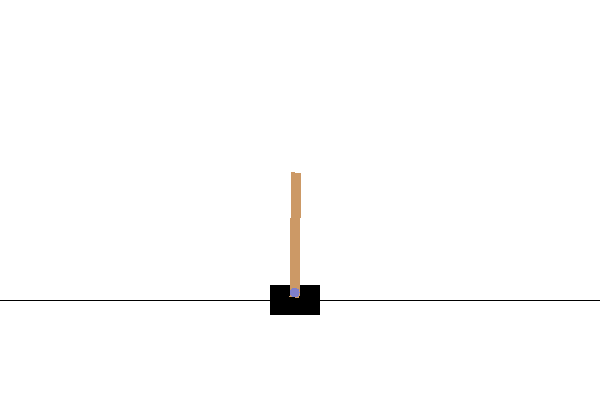

DQN agent achieves 200.0 return.


In [12]:
# Run this cell without modification

# Render the learned behavior
eval_reward, eval_info = evaluate(
    policy=pytorch_trainer.policy, 
    num_episodes=1, 
    env_name=pytorch_trainer.env_name,
    render="rgb_array",  # Visualize the behavior here in the cell 
)

animate(eval_info["frames"])

print("DQN agent achieves {} return.".format(eval_reward))

### Section 3.4: Train DQN agents in MetaDrive

In [13]:
# Run this cell without modification

def register_metadrive():
    from gym.envs.registration import register
    from gym import Wrapper
    try:
        from metadrive.envs import MetaDriveEnv
        from metadrive.utils.config import merge_config_with_unknown_keys
    except ImportError as e:
        print("Please install MetaDrive through: pip install git+https://github.com/decisionforce/metadrive")
        raise e

    env_names = []
    try:
        class MetaDriveEnvD(Wrapper):
            def __init__(self, config, *args, **kwargs):
                super().__init__(MetaDriveEnv(config))
                self.action_space = gym.spaces.Discrete(int(np.prod(self.env.action_space.nvec)))

        _make_env = lambda config=None: MetaDriveEnvD(config)
        
        env_name = "MetaDrive-Tut-Easy-v0"
        register(id=env_name, entry_point=_make_env, kwargs={"config": dict(
            map="S",
            start_seed=0,
            environment_num=1,
            horizon=200,
            discrete_action=True,
            discrete_steering_dim=3, 
            discrete_throttle_dim=3
        )})
        env_names.append(env_name)
        
        env_name = "MetaDrive-Tut-Hard-v0"
        register(id=env_name, entry_point=_make_env, kwargs={"config": dict(
            map="CCC",
            start_seed=0,
            environment_num=10,
            discrete_action=True,
            discrete_steering_dim=5, 
            discrete_throttle_dim=5
        )})
        env_names.append(env_name)
    except gym.error.Error as e:
        print("Information when registering MetaDrive: ", e)
    else:
        print("Successfully registered MetaDrive environments: ", env_names)

In [14]:
# Run this cell without modification

register_metadrive()

Successfully registered the following environments: ['MetaDrive-validation-v0', 'MetaDrive-10env-v0', 'MetaDrive-100envs-v0', 'MetaDrive-1000envs-v0', 'SafeMetaDrive-validation-v0', 'SafeMetaDrive-10env-v0', 'SafeMetaDrive-100envs-v0', 'SafeMetaDrive-1000envs-v0', 'MARLTollgate-v0', 'MARLBottleneck-v0', 'MARLRoundabout-v0', 'MARLIntersection-v0', 'MARLParkingLot-v0', 'MARLMetaDrive-v0'].
Successfully registered MetaDrive environments:  ['MetaDrive-Tut-Easy-v0', 'MetaDrive-Tut-Hard-v0']


In [15]:
# Run this cell without modification

# Build the test trainer.
test_trainer = DQNTrainer(dict(env_name="MetaDrive-Tut-Easy-v0"))

# Test compute_values
for _ in range(10):
    fake_state = test_trainer.env.observation_space.sample()
    processed_state = test_trainer.process_state(fake_state)
    assert processed_state.shape == (test_trainer.obs_dim, ), processed_state.shape
    values = test_trainer.compute_values(processed_state)
    assert values.shape == (test_trainer.act_dim, ), values.shape

    test_trainer.train()

print("Now your codes should be bug-free.")
test_trainer.env.close()
del test_trainer

Setting up self.network with obs dim: 259 and action dim: 9
Num inputs: 259, Num actions: 9
Num inputs: 259, Num actions: 9
Now your codes should be bug-free.


In [16]:
# Run this cell without modification

env_name = "MetaDrive-Tut-Easy-v0"

pytorch_trainer2, _ = run(DQNTrainer, dict(
    max_episode_length=200,
    max_iteration=5000,
    evaluate_interval=10,
    evaluate_num_episodes=10,
    learning_rate=0.0001,
    clip_norm=10.0,
    memory_size=1000000,
    learn_start=2000,
    eps=0.1,
    target_update_freq=5000,
    learn_freq=16,
    batch_size=256,
    env_name=env_name
), reward_threshold=120)


pytorch_trainer2.save("dqn_trainer_metadrive_easy.pt")

Setting up self.network with obs dim: 259 and action dim: 9
Num inputs: 259, Num actions: 9
Num inputs: 259, Num actions: 9


:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager


(1.4s,+1.4s) Iter 0, Step 199, episodic return is -0.57. {'episode_len': 199.0}
(4.0s,+2.6s) Iter 10, Step 2189, episodic return is -0.57. {'loss': 0.0029, 'episode_len': 199.0}
(6.1s,+2.1s) Iter 20, Step 3016, episodic return is -0.01. {'loss': 0.0722, 'episode_len': 199.0}
(8.2s,+2.1s) Iter 30, Step 4526, episodic return is 62.42. {'loss': 0.0793, 'episode_len': 199.0}
5048 steps has passed since last update. Now update the parameter of the behavior policy. Current step: 5048
(10.3s,+2.1s) Iter 40, Step 5342, episodic return is 125.58. {'loss': 0.238, 'episode_len': 50.0, 'success_rate': 0.0}
In 40 iteration, episodic return 125.581 is greater than reward threshold 120. Congratulation! Now we exit the training process.
Environment is closed.


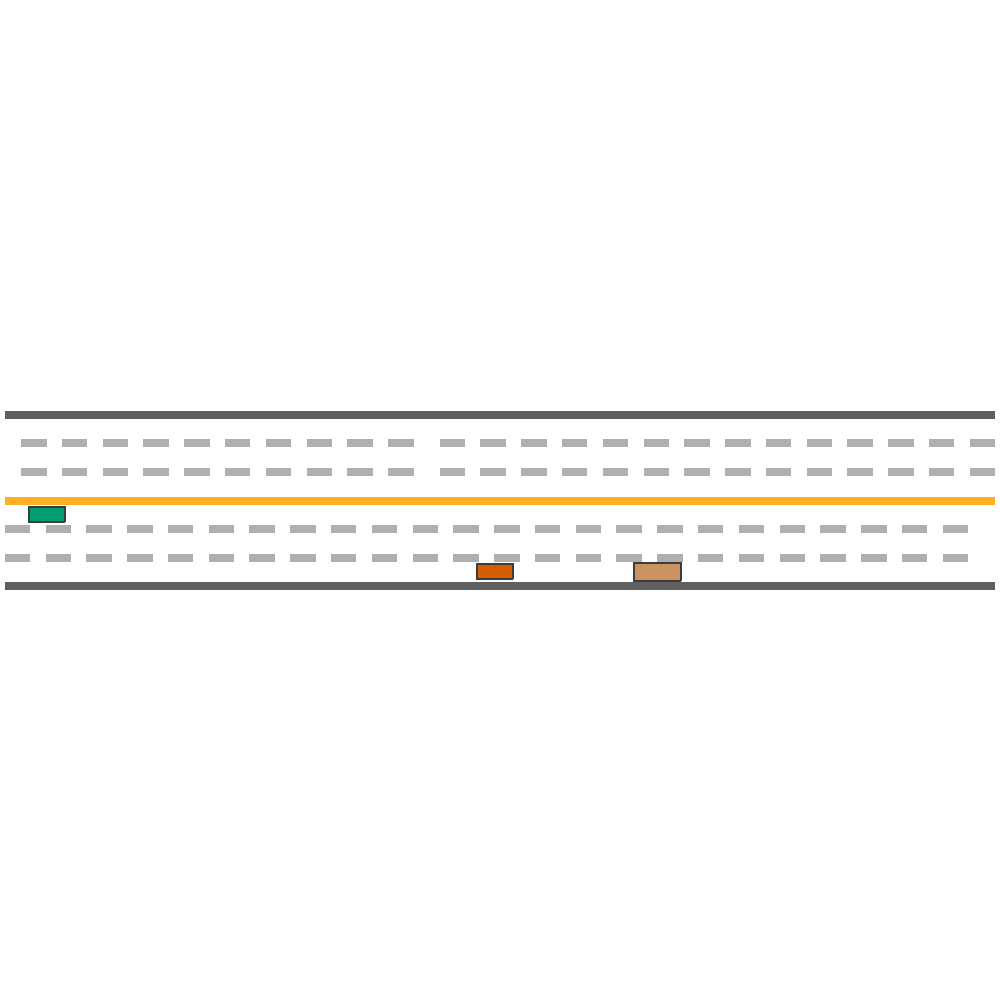

DQN agent achieves 125.5814677761268 return in MetaDrive easy environment.


In [17]:
# Run this cell without modification

# Render the learned behavior
# NOTE: The learned agent is marked by green color.
eval_reward, eval_info = evaluate(
    policy=pytorch_trainer2.policy, 
    num_episodes=1, 
    env_name=pytorch_trainer2.env_name,
    render="topdown",  # Visualize the behaviors in top-down view
    verbose=True
)

frames = [pygame.surfarray.array3d(f).swapaxes(0, 1) for f in eval_info["frames"]]

animate(frames)

print("DQN agent achieves {} return in MetaDrive easy environment.".format(eval_reward))

### Section 3.5: Train agent to solve harder driving task using DQN!

We will train agent to solve a hard MetaDrive environment with multiple curved road segments. We will visualize the behavior of agent later.

The training log of my experiment is left below for your information. As you can see the performance is not good in terms of the zero success rate.

**GOAL: achieve episodic return > 50.**
    
    
**BONUS!!** **can be earned if you can improve the training performance by adjusting hyper-parameters and optimizing code. Improvement means achieving > 0.0 success rate. However, I can't promise that it is feasible to use DQN algorithm to solve this task.** Please creates a independent markdown cell to highlight your improvement.

In [18]:
# Run this cell without modification
# (of course you can adjust hyper-parameters if you like)

# We might want to stop the training and restore later.
# Therefore, we don't use the `run` function but instead
# explicitly expose the trainer here.
# This can avoid the loss of trained agent if any unexpected error
# happens during training and thus you can stop at any time and then
# run next cell to see the visualization.
# This also allow us to save and restore the intermiedate agents if want.


metadrive_config = dict(
    max_episode_length=1000,
    max_iteration=5000,
    evaluate_interval=50,
    evaluate_num_episodes=5,
    learning_rate=0.0001,
    clip_norm=10.0,
    memory_size=1000000,
    learn_start=5000,
    eps=0.2,
    target_update_freq=5000,
    learn_freq=16,
    batch_size=256,
    env_name="MetaDrive-Tut-Hard-v0"
)

metadrive_reward_threshold = 1000

metadrive_trainer = DQNTrainer(metadrive_config)

# We might want to load trained trainer to pick up training:
if os.path.isfile("dqn_trainer_metadrive_hard.pt"):
    metadrive_trainer.load("dqn_trainer_metadrive_hard.pt")


metadrive_config = metadrive_trainer.config
start = now = time.time()
stats = []
total_steps = 0
try:
    for i in range(metadrive_config['max_iteration'] + 1):
        stat = metadrive_trainer.train()
        stat = stat or {}
        stats.append(stat)

        metadrive_trainer.save("dqn_trainer_metadrive_hard.pt")
        
        if "episode_len" in stat:
            total_steps += stat["episode_len"]
        if i % metadrive_config['evaluate_interval'] == 0 or \
                i == metadrive_config["max_iteration"]:
            reward, _ = metadrive_trainer.evaluate(
                metadrive_config.get("evaluate_num_episodes", 50), 
                max_episode_length=metadrive_config.get("max_episode_length", 1000)
            )
            print("({:.1f}s,+{:.1f}s) Iter {}, {}episodic return"
                  " is {:.2f}. {}".format(
                        time.time() - start, 
                        time.time() - now, 
                        i, 
                        "" if total_steps == 0 else "Step {}, ".format(total_steps),
                        reward,
                        {k: round(np.mean(v), 4) for k, v in stat.items() 
                        if not np.isnan(v) and k != "frames"
                        }
                              if stat else ""
                  ))
            now = time.time()
        if metadrive_reward_threshold is not None and reward > metadrive_reward_threshold:
            print("In {} iteration, episodic return {:.3f} is "
                  "greater than reward threshold {}. Congratulation! Now we "
                  "exit the training process.".format(
                i, reward, metadrive_reward_threshold))
            break
except Exception as e:
    print("Error happens during training: ")
    raise e
finally:
    if hasattr(metadrive_trainer.env, "close"):
        metadrive_trainer.env.close()
        print("Environment is closed.")


Setting up self.network with obs dim: 259 and action dim: 25
Num inputs: 259, Num actions: 25
Num inputs: 259, Num actions: 25


:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager


(1.9s,+1.9s) Iter 0, Step 139, episodic return is 71.17. {'episode_len': 139.0, 'success_rate': 0.0}
5062 steps has passed since last update. Now update the parameter of the behavior policy. Current step: 5062
(19.6s,+17.7s) Iter 50, Step 7302, episodic return is 58.49. {'loss': 7.6031, 'episode_len': 121.0, 'success_rate': 0.0}
5040 steps has passed since last update. Now update the parameter of the behavior policy. Current step: 10102
5864 steps has passed since last update. Now update the parameter of the behavior policy. Current step: 15966
(41.2s,+21.7s) Iter 100, Step 18123, episodic return is 47.38. {'loss': 5.2185, 'episode_len': 179.0, 'success_rate': 0.0}
5062 steps has passed since last update. Now update the parameter of the behavior policy. Current step: 21028
(57.9s,+16.7s) Iter 150, Step 24464, episodic return is 49.20. {'loss': 4.7272, 'episode_len': 106.0, 'success_rate': 0.0}
5553 steps has passed since last update. Now update the parameter of the behavior policy. Cur

5052 steps has passed since last update. Now update the parameter of the behavior policy. Current step: 224121
5096 steps has passed since last update. Now update the parameter of the behavior policy. Current step: 229217
(543.7s,+25.0s) Iter 1500, Step 227801, episodic return is 14.59. {'loss': 6.3008, 'episode_len': 84.0, 'success_rate': 0.0}
5072 steps has passed since last update. Now update the parameter of the behavior policy. Current step: 234289
(560.5s,+16.8s) Iter 1550, Step 234642, episodic return is 66.19. {'loss': 6.7128, 'episode_len': 97.0, 'success_rate': 0.0}
5478 steps has passed since last update. Now update the parameter of the behavior policy. Current step: 239767
(581.1s,+20.6s) Iter 1600, Step 242860, episodic return is 75.65. {'loss': 2.6742, 'episode_len': 55.0, 'success_rate': 0.0}
5037 steps has passed since last update. Now update the parameter of the behavior policy. Current step: 244804
5476 steps has passed since last update. Now update the parameter of t

(1108.5s,+20.0s) Iter 2850, Step 444766, episodic return is 67.26. {'loss': 8.465, 'episode_len': 283.0, 'success_rate': 0.0}
5175 steps has passed since last update. Now update the parameter of the behavior policy. Current step: 452137
5035 steps has passed since last update. Now update the parameter of the behavior policy. Current step: 457172
(1133.2s,+24.7s) Iter 2900, Step 454644, episodic return is 68.35. {'loss': 6.7542, 'episode_len': 79.0, 'success_rate': 0.0}
5019 steps has passed since last update. Now update the parameter of the behavior policy. Current step: 462191
(1157.0s,+23.8s) Iter 2950, Step 462567, episodic return is 95.38. {'loss': 6.6237, 'episode_len': 86.0, 'success_rate': 0.0}
5077 steps has passed since last update. Now update the parameter of the behavior policy. Current step: 467268
5878 steps has passed since last update. Now update the parameter of the behavior policy. Current step: 473146
(1185.6s,+28.6s) Iter 3000, Step 472394, episodic return is 55.73. 

(1816.8s,+36.2s) Iter 4100, Step 686730, episodic return is 65.86. {'loss': 13.1, 'episode_len': 42.0, 'success_rate': 0.0}
5485 steps has passed since last update. Now update the parameter of the behavior policy. Current step: 694978
5110 steps has passed since last update. Now update the parameter of the behavior policy. Current step: 700088
(1854.0s,+37.2s) Iter 4150, Step 698761, episodic return is 79.83. {'loss': 8.6977, 'episode_len': 109.0, 'success_rate': 0.0}
5050 steps has passed since last update. Now update the parameter of the behavior policy. Current step: 705138
5108 steps has passed since last update. Now update the parameter of the behavior policy. Current step: 710246
(1887.2s,+33.3s) Iter 4200, Step 709037, episodic return is 49.88. {'loss': 8.8501, 'episode_len': 98.0, 'success_rate': 0.0}
5370 steps has passed since last update. Now update the parameter of the behavior policy. Current step: 715616
5491 steps has passed since last update. Now update the parameter of

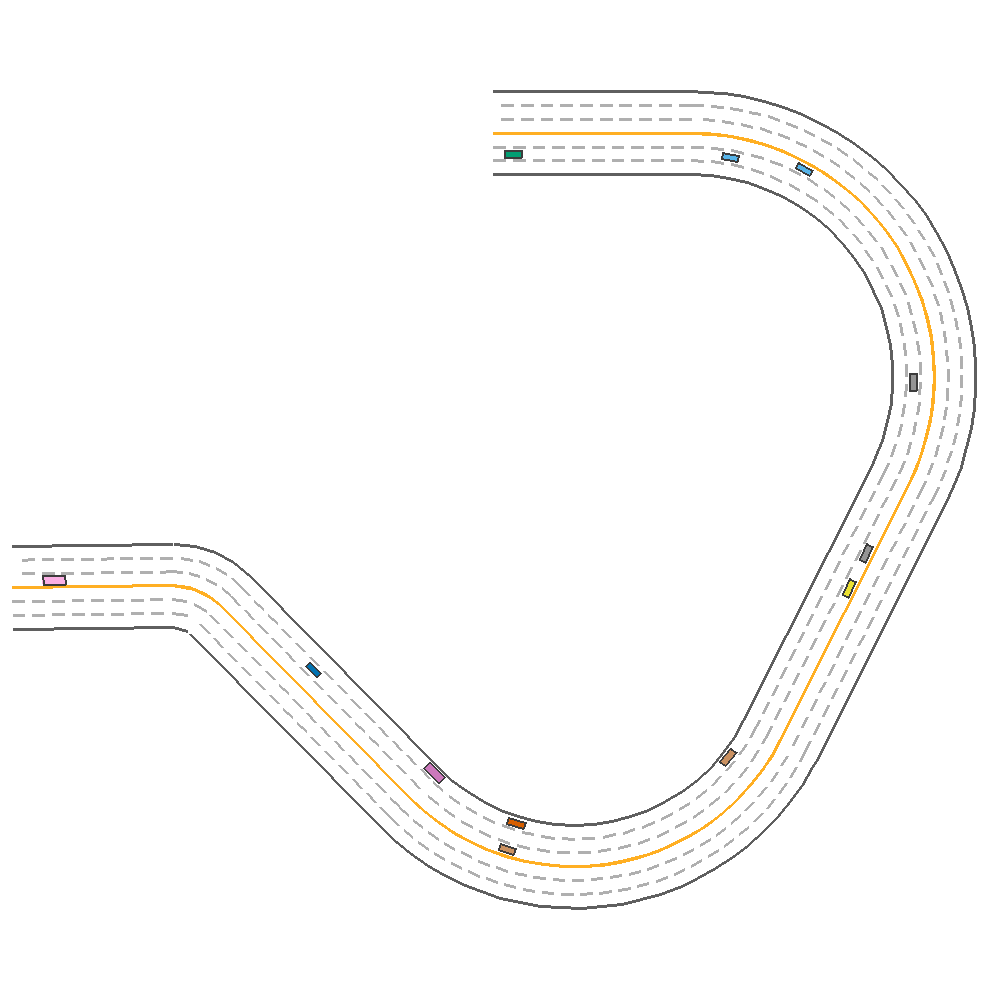

DQN agent achieves 58.264131646588304 return in MetaDrive hard environment.


In [19]:
# Run this cell without modification

# Render the learned behavior
# NOTE: The learned agent is marked by green color.
eval_reward, eval_info = evaluate(
    policy=metadrive_trainer.policy, 
    num_episodes=1, 
    env_name=metadrive_trainer.env_name,
    render="topdown",  # Visualize the behaviors in top-down view
    verbose=True
)

frames = [pygame.surfarray.array3d(f).swapaxes(0, 1) for f in eval_info["frames"]]

animate(frames)

print("DQN agent achieves {} return in MetaDrive hard environment.".format(eval_reward))

## Section 4: Policy gradient methods - REINFORCE

(30 / 100 points)

Unlike supervised learning, in RL the optimization objective return is not differentiable w.r.t. the neural network parameters. This can be workaround via ***Policy Gradient***. It can be proved that policy gradient is an unbiased estimator of the gradient of the objective.

Concretely, let's consider such optimization objective:

$$Q = \mathbb E_{\text{possible trajectories}} \sum_t r(a_t, s_t) = \sum_{s_0, a_0,..} p(s_0, a_0, ..., s_t, a_t) r(s_0, a_0, ..., s_t, a_t) = \sum_{\tau} p(\tau)r(\tau)$$ 

wherein $\sum_t r(a_t, s_t) = r(\tau)$ is the return of trajectory $\tau = (s_0, a_0, ...)$. We remove the discount factor for simplicity.
Since we want to maximize Q, we can simply compute the gradient of Q w.r.t. parameter $\theta$ (which is implictly included in $p(\tau)$):

$$\nabla_\theta Q = \nabla_\theta \sum_{\tau} p(\tau)r(\tau) = \sum_{\tau} r(\tau) \nabla_\theta p(\tau)$$

Apply a famous trick: $\nabla_\theta p(\tau) = p(\tau)\cfrac{\nabla_\theta p(\tau)}{p(\tau)} = p(\tau)\nabla_\theta \log p(\tau)$. 

Introducing a log term can change the product of probabilities to sum of log probabilities. Now we can expand the log of product above to sum of log:

$$p_\theta(\tau) = p(s_0, a_0, ...) = p(s_0) \prod_t \pi_\theta (a_t|s_t) p(s_{t+1}|s_t, a_t)$$

$$\log p_\theta (\tau) = \log p(s_0) + \sum_t \log \pi_\theta(a_t|s_t) + \sum_t \log p(s_{t+1}|s_t, a_t)$$

You can find that the first and third term are not correlated to the parameter of policy $\pi_\theta(\cdot)$. So when we moving back to $\nabla_\theta Q$, we find 

$$\nabla_\theta Q =
\sum_{\tau} r(\tau) \nabla_\theta p(\tau) =  
\sum_{\tau} r(\tau) p(\tau)\nabla_\theta \log p(\tau) =
\sum p_\theta(\tau) ( \sum_t  \nabla_\theta \log \pi_\theta(a_t|s_t) ) r(\tau) d\tau$$

When we sample sufficient amount of data from the environment, the above equation can be estimated via:

$$\nabla_\theta Q =\cfrac{1}{N}\sum_{i=1}^N [( \sum_t  \nabla_\theta \log \pi_\theta(a_{i,t}|s_{i,t}) (\sum_{t'=t} \gamma^{t'-t} r(s_{i,t'}, a_{i,t'}) )]$$

This algorithm is called REINFORCE algorithm, which is a Monte Carlo Policy Gradient algorithm with long history. In this section, we will implement the it using pytorch.

The policy network is composed by two parts: 

1. A basic neural network serves as the function approximator. It output raw values parameterizing the action distribution given current observation. We will reuse PytorchModel here.
2. A distribution layer builds upon the neural network to wrap the raw logits output from neural network to a distribution and provides API for sampling action and computing log probability.

### Section 4.1: Build REINFORCE

In [20]:
# Run this cell without modification

class PGNetwork(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_units=128):
        super(PGNetwork, self).__init__()
        self.network = PytorchModel(obs_dim, act_dim, hidden_units)

    def forward(self, obs):
        logit = self.network(obs)
        
        # [TODO] Create an object of the class "torch.distributions.Categorical" 
        #  with logit. Hint: don't mess up `logits`
        # Then sample an action from it.
        action = None
        pass
        
        return action

    def log_prob(self, obs, act):
        logits = self.network(obs)
        
        # [TODO] Create an object of the class "torch.distributions.Categorical" 
        # Then get the log probability of the action `act` in this distribution.
        log_prob = None
        pass
        
        return log_prob

# Note that we do not implement GaussianPolicy here. So we can't
# apply our algorithm to the environment with continous action.


In [21]:
# Solve the TODOs and remove `pass`

PG_DEFAULT_CONFIG = merge_config(dict(
    normalize_advantage=True,
    
    clip_norm=10.0,
    clip_gradient=True,
    
    hidden_units=100,
    
        
    max_iteration=1000,
    
    train_batch_size=1000,
    gamma=0.99,
    learning_rate=0.01,
    
    
    env_name="CartPole-v0",
    
), DEFAULT_CONFIG)



class PGTrainer(AbstractTrainer):
    def __init__(self, config=None):
        config = merge_config(config, PG_DEFAULT_CONFIG)
        super().__init__(config)
        
        self.iteration = 0
        self.start_time = time.time()
        self.iteration_time = self.start_time
        self.total_timesteps = 0
        self.total_episodes = 0

        # build the model
        self.initialize_parameters()

    def initialize_parameters(self):
        """Build the policy network and related optimizer"""
        # Detect whether you have GPU or not. Remember to call X.to(self.device)
        # if necessary.
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        
        # Build the policy network
        self.network = PGNetwork(
            self.obs_dim, self.act_dim,
            hidden_units=self.config["hidden_units"]
        ).to(self.device)
        
        # Build the Adam optimizer.
        self.optimizer = torch.optim.Adam(
            self.network.parameters(),
            lr=self.config["learning_rate"]
        )

    def to_tensor(self, array):
        """Transform a numpy array to a pytorch tensor"""
        return torch.from_numpy(array).type(torch.float32).to(self.device)

    def to_array(self, tensor):
        """Transform a pytorch tensor to a numpy array"""
        ret = tensor.cpu().detach().numpy()
        if ret.size == 1:
            ret = ret.item()
        return ret
    
    def save(self, loc="model.pt"):
        torch.save(self.network.state_dict(), loc)
        
    def load(self, loc="model.pt"):
        self.network.load_state_dict(torch.load(loc))

    def compute_action(self, observation, eps=None):
        """Compute the action for single observation. eps is useless here."""
        assert observation.ndim == 1
        # [TODO] Sample an action from action distribution given by the policy
        # Hint: The input of policy network is a batch of data, so you need to
        #  expand the first dimension of observation before feeding it to policy network.
        pass

        return action

    def compute_log_probs(self, observation, action):
        """Compute the log probabilities of a batch of state-action pair"""
        # [TODO] Using the function of policy network to get log probs.
        # Hint: Remember to transform the data into tensor before feeding it.
        pass

        return log_probs

    def process_samples(self, samples):
        """Process samples and add advantages in it"""
        values = []
        for reward_list in samples["reward"]:
            # reward_list contains rewards in one episode
            returns = np.zeros_like(reward_list, dtype=np.float32)
            Q = 0
            
            # [TODO] Scan the episode in a reverse order and compute the
            # discounted return at each time step. Fill the array `returns`
            pass
                
            values.append(returns)

        # We call the values advantage here.
        advantages = np.concatenate(values)

        if self.config["normalize_advantage"]:
            # [TODO] normalize the advantage so that it's mean is
            # almost 0 and the its standard deviation is almost 1.
            pass
        
        samples["advantages"] = advantages
        return samples, {}

    def update_network(self, processed_samples):
        """Update the policy network"""
        advantages = self.to_tensor(processed_samples["advantages"])
        flat_obs = np.concatenate(processed_samples["obs"])
        flat_act = np.concatenate(processed_samples["act"])

        self.network.train()
        self.optimizer.zero_grad()

        log_probs = self.compute_log_probs(flat_obs, flat_act)

        assert log_probs.shape == advantages.shape, "log_probs shape {} is not " \
            "compatible with advantages {}".format(log_probs.shape, advantages.shape)
        
        # [TODO] Compute the loss using log probabilities and advantages.
        loss = None
        pass
        
        loss.backward()
        
        # Clip the gradient
        torch.nn.utils.clip_grad_norm_(
            self.network.parameters(), self.config["clip_gradient"]
        )

        self.optimizer.step()
        self.network.eval()
        
        update_info = {
            "policy_loss": loss.item(),
            "mean_log_prob": torch.mean(log_probs).item(),
            "mean_advantage": torch.mean(advantages).item()
        }
        return update_info
    
    # ===== Training-related functions =====
    def collect_samples(self):
        """Here we define the pipeline to collect sample even though
        any specify functions are not implemented yet.
        """
        iter_timesteps = 0
        iter_episodes = 0
        episode_lens = []
        episode_rewards = []
        episode_obs_list = []
        episode_act_list = []
        episode_reward_list = []
        success_list = []
        while iter_timesteps <= self.config["train_batch_size"]:
            obs_list, act_list, reward_list = [], [], []
            obs = self.env.reset()
            steps = 0
            episode_reward = 0
            while True:
                act = self.compute_action(obs)
                
                # print("ACT: ", act, type(act))
                
                next_obs, reward, done, step_info = self.env.step(act)

                obs_list.append(obs)
                act_list.append(act)
                reward_list.append(reward)

                obs = next_obs.copy()
                steps += 1
                episode_reward += reward
                if done or steps > self.config["max_episode_length"]:
                    if "arrive_dest" in step_info:
                        success_list.append(step_info["arrive_dest"])
                    break
            iter_timesteps += steps
            iter_episodes += 1
            episode_rewards.append(episode_reward)
            episode_lens.append(steps)
            episode_obs_list.append(np.array(obs_list, dtype=np.float32))
            episode_act_list.append(np.array(act_list, dtype=np.float32))
            episode_reward_list.append(np.array(reward_list, dtype=np.float32))
        
        # [TODO] Uncomment everything below and understand the data structure:
        # The return `samples` is a dict that contains several fields.
        # Each field (key-value pair) contains a list.
        # Each element in list is a list represent the data in one trajectory (episode).
        # Each episode list contains the data of that field of all time steps in that episode.
        # The return `sample_info` is a dict contains logging item name and its value.
        """
        samples = {
            "obs": episode_obs_list,
            "act": episode_act_list,
            "reward": episode_reward_list
        }
        """
        pass
        
        sample_info = {
            "iter_timesteps": iter_timesteps,
            "iter_episodes": iter_episodes,
            "performance": np.mean(episode_rewards),  # help drawing figures
            "ep_len": float(np.mean(episode_lens)),
            "ep_ret": float(np.mean(episode_rewards)),
            "episode_len": sum(episode_lens),
            "success_rate": np.mean(success_list)
        }
        return samples, sample_info
    
    def process_samples(self, samples):
        """Process samples and add advantages in it"""
        values = []
        for reward_list in samples["reward"]:
            # reward_list contains rewards in one episode
            returns = np.zeros_like(reward_list, dtype=np.float32)
            Q = 0
            
            # [TODO] Scan the episode in a reverse order and compute the
            # discounted return at each time step. Fill the array `returns`
            # Each entry to the returns is the target Q value of current time step
            pass
                
            values.append(returns)

        # We call the values advantage here.
        advantages = np.concatenate(values)

        if self.config["normalize_advantage"]:
            # [TODO] normalize the advantage so that it's mean is
            # almost 0 and the its standard deviation is almost 1.
            pass
        
        samples["advantages"] = advantages
        return samples, {}
        
    # ===== Training iteration =====
    def train(self):
        """Here we defined the training pipeline using the abstract
        functions."""
        info = dict(iteration=self.iteration)

        # [TODO] Uncomment the following block and go through the learning 
        # pipeline.
        """
        # Collect samples
        samples, sample_info = self.collect_samples()
        info.update(sample_info)

        # Process samples
        processed_samples, processed_info = self.process_samples(samples)
        info.update(processed_info)

        # Update the model
        update_info = self.update_network(processed_samples)
        info.update(update_info)
        """
        pass

        now = time.time()
        self.iteration += 1
        self.total_timesteps += info.pop("iter_timesteps")
        self.total_episodes += info.pop("iter_episodes")
        
        # info["iter_time"] = now - self.iteration_time
        # info["total_time"] = now - self.start_time
        info["total_episodes"] = self.total_episodes
        info["total_timesteps"] = self.total_timesteps
        self.iteration_time = now
        
        # print("INFO: ", info)
        
        return info


### Section 4.2: Test REINFORCE

In [22]:
# Run this cell without modification

# Test advantage computing
test_trainer = PGTrainer({"normalize_advantage": False})
test_trainer.train()
fake_sample = {"reward": [[2, 2, 2, 2, 2]]}
np.testing.assert_almost_equal(
    test_trainer.process_samples(fake_sample)[0]["reward"][0],
    fake_sample["reward"][0]
)
np.testing.assert_almost_equal(
    test_trainer.process_samples(fake_sample)[0]["advantages"],
    np.array([9.80199, 7.880798, 5.9402, 3.98, 2.], dtype=np.float32)
)

# Test advantage normalization
test_trainer = PGTrainer(
    {"normalize_advantage": True, "env_name": "LunarLander-v2"})
test_adv = test_trainer.process_samples(fake_sample)[0]["advantages"]
np.testing.assert_almost_equal(test_adv.mean(), 0.0)
np.testing.assert_almost_equal(test_adv.std(), 1.0)

# Test the shape of functions' returns
fake_observation = np.array([
    test_trainer.env.observation_space.sample() for i in range(10)
])
fake_action = np.array([
    test_trainer.env.action_space.sample() for i in range(10)
])
assert test_trainer.to_tensor(fake_observation).shape == torch.Size([10, 8])
assert np.array(test_trainer.compute_action(fake_observation[0])).shape == ()
assert test_trainer.compute_log_probs(fake_observation, fake_action).shape == \
       torch.Size([10])

print("Test Passed!")


Num inputs: 4, Num actions: 2
Num inputs: 8, Num actions: 4
Test Passed!


### Section 4.3: Train REINFORCE in CartPole and see the impact of advantage normalization

In [23]:
# Run this cell without modification

pg_trainer_no_na, pg_result_no_na = run(PGTrainer, dict(
    learning_rate=0.01,
    max_episode_length=200,
    train_batch_size=200,
    env_name="CartPole-v0",
    normalize_advantage=False,  # <<== Here!
    
    evaluate_interval=10,
    evaluate_num_episodes=10,
), 195.0)


Num inputs: 4, Num actions: 2
(0.1s,+0.1s) Iter 0, Step 209, episodic return is 28.40. {'iteration': 0.0, 'performance': 26.125, 'ep_len': 26.125, 'ep_ret': 26.125, 'episode_len': 209.0, 'policy_loss': 10.5007, 'mean_log_prob': -0.6993, 'mean_advantage': 14.9228, 'total_episodes': 8.0, 'total_timesteps': 209.0}
(0.5s,+0.4s) Iter 10, Step 2659, episodic return is 81.60. {'iteration': 10.0, 'performance': 61.5, 'ep_len': 61.5, 'ep_ret': 61.5, 'episode_len': 246.0, 'policy_loss': 10.6949, 'mean_log_prob': -0.4362, 'mean_advantage': 26.0069, 'total_episodes': 53.0, 'total_timesteps': 2659.0}
(0.9s,+0.4s) Iter 20, Step 5109, episodic return is 61.40. {'iteration': 20.0, 'performance': 78.0, 'ep_len': 78.0, 'ep_ret': 78.0, 'episode_len': 234.0, 'policy_loss': 12.8362, 'mean_log_prob': -0.3841, 'mean_advantage': 31.4143, 'total_episodes': 96.0, 'total_timesteps': 5109.0}
(1.3s,+0.4s) Iter 30, Step 7525, episodic return is 50.50. {'iteration': 30.0, 'performance': 52.5, 'ep_len': 52.5, 'ep_ret

In [24]:
# Run this cell without modification

pg_trainer_na, pg_result_na = run(PGTrainer, dict(
    learning_rate=0.01,
    max_episode_length=200,
    train_batch_size=200,
    env_name="CartPole-v0",
    normalize_advantage=True,  # <<== Here!
    
    evaluate_interval=10,
    evaluate_num_episodes=10,
), 195.0)


Num inputs: 4, Num actions: 2
(0.0s,+0.0s) Iter 0, Step 204, episodic return is 13.40. {'iteration': 0.0, 'performance': 22.6667, 'ep_len': 22.6667, 'ep_ret': 22.6667, 'episode_len': 204.0, 'policy_loss': 0.0007, 'mean_log_prob': -0.6939, 'mean_advantage': 0.0, 'total_episodes': 9.0, 'total_timesteps': 204.0}
(0.4s,+0.3s) Iter 10, Step 2321, episodic return is 46.90. {'iteration': 10.0, 'performance': 31.1429, 'ep_len': 31.1429, 'ep_ret': 31.1429, 'episode_len': 218.0, 'policy_loss': -0.006, 'mean_log_prob': -0.6633, 'mean_advantage': -0.0, 'total_episodes': 110.0, 'total_timesteps': 2321.0}
(0.8s,+0.4s) Iter 20, Step 4620, episodic return is 69.40. {'iteration': 20.0, 'performance': 53.0, 'ep_len': 53.0, 'ep_ret': 53.0, 'episode_len': 212.0, 'policy_loss': -0.0598, 'mean_log_prob': -0.6353, 'mean_advantage': -0.0, 'total_episodes': 160.0, 'total_timesteps': 4620.0}
(1.4s,+0.6s) Iter 30, Step 7625, episodic return is 169.20. {'iteration': 30.0, 'performance': 182.0, 'ep_len': 182.0, 'e

Text(0.5, 1.0, 'Policy Gradient: Advantage normalization matters!')

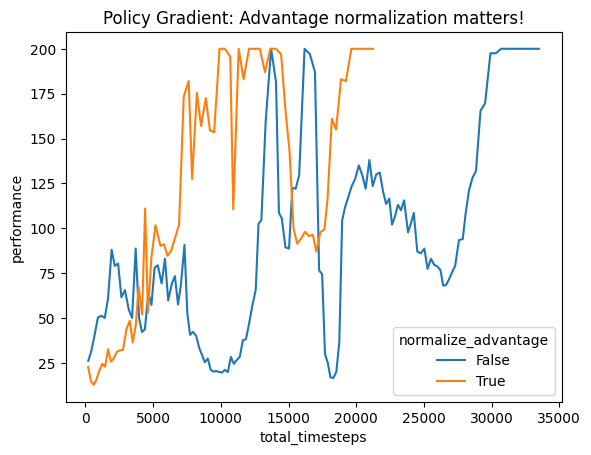

In [25]:
# Run this cell without modification

pg_result_no_na_df = pd.DataFrame(pg_result_no_na)
pg_result_na_df = pd.DataFrame(pg_result_na)
pg_result_no_na_df["normalize_advantage"] = False
pg_result_na_df["normalize_advantage"] = True

ax = sns.lineplot(
    x="total_timesteps", 
    y="performance", 
    data=pd.concat([pg_result_no_na_df, pg_result_na_df]).reset_index(), hue="normalize_advantage",
)
ax.set_title("Policy Gradient: Advantage normalization matters!")

### Section 4.4: Train REINFORCE in MetaDrive-Easy

In [27]:
# Run this cell without modification

env_name = "MetaDrive-Tut-Easy-v0"

pg_trainer_metadrive_easy, pg_trainer_metadrive_easy_result = run(PGTrainer, dict(
    train_batch_size=2000,
    normalize_advantage=True,
    max_episode_length=200,
    max_iteration=5000,
    evaluate_interval=10,
    evaluate_num_episodes=10,
    learning_rate=0.001,
    clip_norm=10.0,
    env_name=env_name
), reward_threshold=120)


pg_trainer_metadrive_easy.save("pg_trainer_metadrive_easy.pt")

:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager


Num inputs: 259, Num actions: 9
(3.1s,+3.1s) Iter 0, Step 2181, episodic return is 2.77. {'iteration': 0.0, 'performance': 1.6023, 'ep_len': 198.2727, 'ep_ret': 1.6023, 'episode_len': 2181.0, 'success_rate': 0.0, 'policy_loss': 0.0042, 'mean_log_prob': -2.1906, 'mean_advantage': -0.0, 'total_episodes': 11.0, 'total_timesteps': 2181.0}
(20.4s,+17.3s) Iter 10, Step 22446, episodic return is 3.42. {'iteration': 10.0, 'performance': 4.7668, 'ep_len': 183.9091, 'ep_ret': 4.7668, 'episode_len': 2023.0, 'success_rate': 0.0, 'policy_loss': 0.0177, 'mean_log_prob': -1.9255, 'mean_advantage': -0.0, 'total_episodes': 114.0, 'total_timesteps': 22446.0}
(41.4s,+21.0s) Iter 20, Step 43504, episodic return is 7.89. {'iteration': 20.0, 'performance': 7.9068, 'ep_len': 180.3333, 'ep_ret': 7.9068, 'episode_len': 2164.0, 'success_rate': 0.0, 'policy_loss': -0.016, 'mean_log_prob': -1.9417, 'mean_advantage': -0.0, 'total_episodes': 232.0, 'total_timesteps': 43504.0}
(61.6s,+20.2s) Iter 30, Step 64334, epi

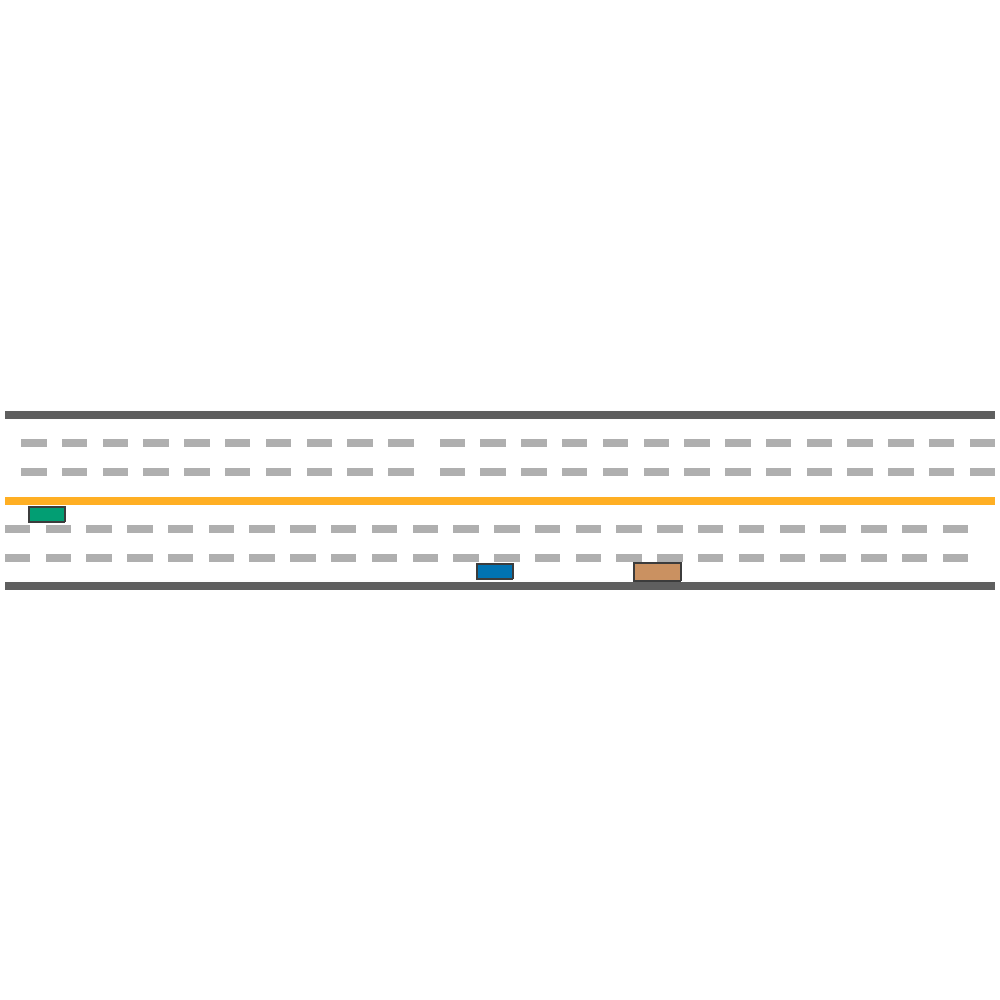

REINFORCE agent achieves 125.5814677761268 return in MetaDrive easy environment.


In [28]:
# Run this cell without modification

# Render the learned behavior
# NOTE: The learned agent is marked by green color.
eval_reward, eval_info = evaluate(
    policy=pg_trainer_metadrive_easy.policy, 
    num_episodes=1, 
    env_name=pg_trainer_metadrive_easy.env_name,
    render="topdown",  # Visualize the behaviors in top-down view
    verbose=True
)

frames = [pygame.surfarray.array3d(f).swapaxes(0, 1) for f in eval_info["frames"]]

animate(frames)

print("REINFORCE agent achieves {} return in MetaDrive easy environment.".format(eval_reward))

## Section 5: Policy gradient with baseline

(20 / 100 points)

We compute the gradient of $Q = \mathop{\mathbb E} \sum_t r(a_t, s_t)$ w.r.t. the parameter to update the policy. Let's consider this case: when you take a so-so action that lead to positive expected return, the policy gradient is also positive and you will update your network toward this action. At the same time a potential better action is ignored.

To tackle this problem, we introduce the "baseline" when computing the policy gradient. The insight behind this is that we want to optimize the policy toward an action that are better than the "average action".

We introduce $b_{t} = \mathbb E_{a_t} \sum_{t'}{\gamma^{t'-t} r(s_{t'}, a_{t'})}$ as the baseline. It average the expected discount return of all possible actions at state $s_t$. So that the "advantage" achieved by action $a_t$ can be evaluated via $\sum_{t'=t} \gamma^{t' -t}r(a_{t'}, s_{t'}) - b_t$

Therefore, the policy gradient becomes:

$$\nabla_\theta Q =\cfrac{1}{N}\sum_{i=1}^N [( \sum_t  \nabla_\theta \log \pi_\theta(a_{i,t}|s_{i,t}) (\sum_{t'} \gamma^{t'-t} r(s_{i,{t’}}, a_{i,t‘}) - b_{i, t})]$$

In our implementation, we estimate the baseline via an extra network `self.baseline`, which has same structure of policy network but output only a scalar value. We use the output of this network to serve as the baseline, while this network is updated by fitting the true value of expected return of current state: $\mathbb E_{a_t} \sum_{t'}{\gamma^{t'-t} r(s_{t'}, a_{t'})}$

The state-action values might have large variance if the reward function has large variance. It is not easy for a neural network to predict targets with large variance and extreme values. In implementation, we use a trick to match the distribution of baseline and values. During training, we first collect a batch of target values: $\{t_i= \mathbb E_{a_t} \sum_{t'}{\gamma^{t'-t} r(s_{t'}, a_{t'})}\}_i$. Then we normalize all targets to a standard distribution with mean = 0 and std = 1. Then we ask the baseline network to fit such normalized targets.

When computing the advantages, instead of using the output of baseline network as the baseline $b$, we firstly match the baseline distribution with state-action values, that is we "de-standarize" the baselines. The transformed baselines $b' = f(b)$ should has the same mean and STD with the action values. 

After that, we compute the advantage of current action: $adv_{i,t} = \sum_{t'} \gamma^{t'-t} r(s_{i,{t'}}, a_{i,t'}) - b'_{i, t}$

By doing this, we mitigate the instability of training baseline.

Hint: We suggest to normalize an array via: `(x - x.mean()) / max(x.std(), 1e-6)`. The max term can mitigate numeraical instability.

### Section 5.1: Build PG method with baseline

In [29]:
class PolicyGradientWithBaselineTrainer(PGTrainer):
    def initialize_parameters(self):
        # Build the actor in name of self.policy
        super().initialize_parameters()
        
        # Build the baseline network using Net class.
        self.baseline = PytorchModel(
            self.obs_dim, 1, self.config["hidden_units"]
        ).to(self.device)
        
        self.baseline_loss = nn.MSELoss()
            
        self.baseline_optimizer = torch.optim.Adam(
            self.baseline.parameters(),
            lr=self.config["learning_rate"]
        )

    def process_samples(self, samples):
        # Call the original process_samples function to get advantages
        tmp_samples, _ = super().process_samples(samples)
        values = tmp_samples["advantages"]
        samples["values"] = values  # We add q_values into samples

        # [TODO] flatten the observations in all trajectories (still a numpy array)
        obs = None
        pass
        
        assert obs.ndim == 2
        assert obs.shape[1] == self.obs_dim
        
        obs = self.to_tensor(obs)
        samples["flat_obs"] = obs

        # [TODO] Compute the baseline by feeding observation to baseline network
        # Hint: `baselines` is a numpy array with the same shape of `values`,
        #  that is: (batch size, )
        baselines = None
        pass
        
        assert baselines.shape == values.shape
        
        # [TODO] Match the distribution of baselines to the values.
        # Hint: We expect to see baselines.std() almost equals to values.std(), 
        #  and baselines.mean() almost equals to values.mean()
        pass

        # Compute the advantage
        advantages = values - baselines
        samples["advantages"] = advantages
        process_info = {"mean_baseline": float(np.mean(baselines))}
        return samples, process_info

    def update_model(self, processed_samples):
        update_info = {}
        update_info.update(self.update_baseline(processed_samples))
        update_info.update(self.update_policy(processed_samples))
        return update_info

    def update_baseline(self, processed_samples):
        self.baseline.train()
        obs = processed_samples["flat_obs"]

        # [TODO] Normalize the values to mean=0, std=1.
        values = processed_samples["values"]
        pass
        
        values = self.to_tensor(values[:, np.newaxis])
        
        baselines = self.baseline(obs)

        self.baseline_optimizer.zero_grad()
        loss = self.baseline_loss(input=baselines, target=values)
        loss.backward()
        
        # Clip the gradient
        torch.nn.utils.clip_grad_norm_(
            self.baseline.parameters(), self.config["clip_gradient"]
        )
        
        self.baseline_optimizer.step()
        self.baseline.eval()
        return dict(baseline_loss=loss.item())


### Section 5.2: Run PG w/ baseline in CartPole

In [30]:
# Run this cell without modification

pg_trainer_wb_cartpole, pg_trainer_wb_cartpole_result = run(PolicyGradientWithBaselineTrainer, dict(
    learning_rate=0.01,
    max_episode_length=200,
    train_batch_size=200,
    
    env_name="CartPole-v0",
    normalize_advantage=True,
    
    evaluate_interval=10,
    evaluate_num_episodes=10,
), 195.0)


Num inputs: 4, Num actions: 2
Num inputs: 4, Num actions: 1
(0.1s,+0.1s) Iter 0, Step 210, episodic return is 25.50. {'iteration': 0.0, 'performance': 19.0909, 'ep_len': 19.0909, 'ep_ret': 19.0909, 'episode_len': 210.0, 'mean_baseline': -0.0, 'policy_loss': 0.0054, 'mean_log_prob': -0.6904, 'mean_advantage': -0.0, 'total_episodes': 11.0, 'total_timesteps': 210.0}


/home/zhenghao/anaconda3/envs/cs269/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/zhenghao/anaconda3/envs/cs269/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0.4s,+0.4s) Iter 10, Step 2378, episodic return is 57.30. {'iteration': 10.0, 'performance': 46.0, 'ep_len': 46.0, 'ep_ret': 46.0, 'episode_len': 230.0, 'mean_baseline': -0.0, 'policy_loss': -0.0926, 'mean_log_prob': -0.6182, 'mean_advantage': 0.0, 'total_episodes': 99.0, 'total_timesteps': 2378.0}
(1.0s,+0.5s) Iter 20, Step 4942, episodic return is 163.10. {'iteration': 20.0, 'performance': 166.0, 'ep_len': 166.0, 'ep_ret': 166.0, 'episode_len': 332.0, 'mean_baseline': 0.0, 'policy_loss': -0.0915, 'mean_log_prob': -0.5396, 'mean_advantage': -0.0, 'total_episodes': 130.0, 'total_timesteps': 4942.0}
(1.6s,+0.6s) Iter 30, Step 8369, episodic return is 95.30. {'iteration': 30.0, 'performance': 170.0, 'ep_len': 170.0, 'ep_ret': 170.0, 'episode_len': 340.0, 'mean_baseline': -0.0, 'policy_loss': -0.0496, 'mean_log_prob': -0.4384, 'mean_advantage': 0.0, 'total_episodes': 151.0, 'total_timesteps': 8369.0}
(2.3s,+0.7s) Iter 40, Step 11596, episodic return is 200.00. {'iteration': 40.0, 'perfor

Text(0.5, 1.0, 'Policy Gradient')

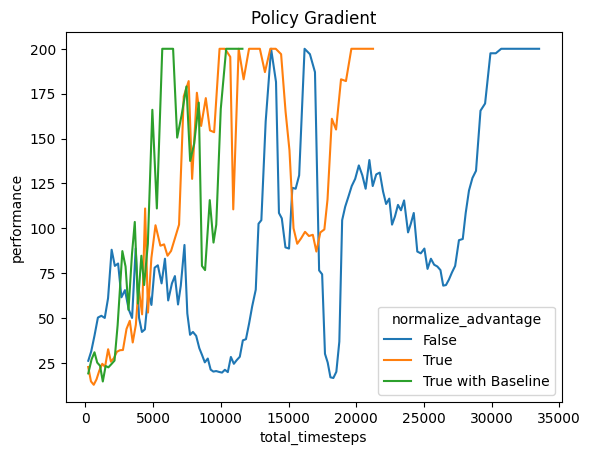

In [31]:
# Run this cell without modification

pg_result_no_na_df = pd.DataFrame(pg_result_no_na)
pg_result_no_na_df["normalize_advantage"] = "False"
pg_result_na_df = pd.DataFrame(pg_result_na)
pg_result_na_df["normalize_advantage"] = "True"
pg_trainer_wb_cartpole_result_df = pd.DataFrame(pg_trainer_wb_cartpole_result)
pg_trainer_wb_cartpole_result_df["normalize_advantage"] = "True with Baseline"
pg_result_df = pd.concat([pg_result_no_na_df, pg_result_na_df, pg_trainer_wb_cartpole_result_df]).reset_index()
ax = sns.lineplot(
    x="total_timesteps", 
    y="performance", 
    data=pg_result_df, hue="normalize_advantage",
)
ax.set_title("Policy Gradient")

### Section 5.3: Run PG w/ baseline in MetaDrive-Easy


In [33]:
# Run this cell without modification

env_name = "MetaDrive-Tut-Easy-v0"

pg_trainer_wb_metadrive_easy, pg_trainer_wb_metadrive_easy_result = run(
    PolicyGradientWithBaselineTrainer, 
    dict(
        train_batch_size=2000,
        normalize_advantage=True,
        max_episode_length=200,
        max_iteration=5000,
        evaluate_interval=10,
        evaluate_num_episodes=10,
        learning_rate=0.001,
        clip_norm=10.0,
        env_name=env_name
    ), 
    reward_threshold=120
)

pg_trainer_wb_metadrive_easy.save("pg_trainer_wb_metadrive_easy.pt")

:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager


Num inputs: 259, Num actions: 9
Num inputs: 259, Num actions: 1
(3.0s,+3.0s) Iter 0, Step 2010, episodic return is 2.76. {'iteration': 0.0, 'performance': 2.2509, 'ep_len': 201.0, 'ep_ret': 2.2509, 'episode_len': 2010.0, 'success_rate': 0.0, 'mean_baseline': -0.0, 'policy_loss': 0.0094, 'mean_log_prob': -2.1904, 'mean_advantage': 0.0, 'total_episodes': 10.0, 'total_timesteps': 2010.0}
(20.5s,+17.5s) Iter 10, Step 22197, episodic return is 10.26. {'iteration': 10.0, 'performance': 8.4135, 'ep_len': 200.3, 'ep_ret': 8.4135, 'episode_len': 2003.0, 'success_rate': 0.0, 'mean_baseline': -0.0, 'policy_loss': -0.0283, 'mean_log_prob': -2.031, 'mean_advantage': 0.0, 'total_episodes': 111.0, 'total_timesteps': 22197.0}
(42.4s,+21.9s) Iter 20, Step 42690, episodic return is 68.54. {'iteration': 20.0, 'performance': 72.4057, 'ep_len': 96.2381, 'ep_ret': 72.4057, 'episode_len': 2021.0, 'success_rate': 0.1429, 'mean_baseline': 0.0, 'policy_loss': -0.0269, 'mean_log_prob': -0.7271, 'mean_advantage':

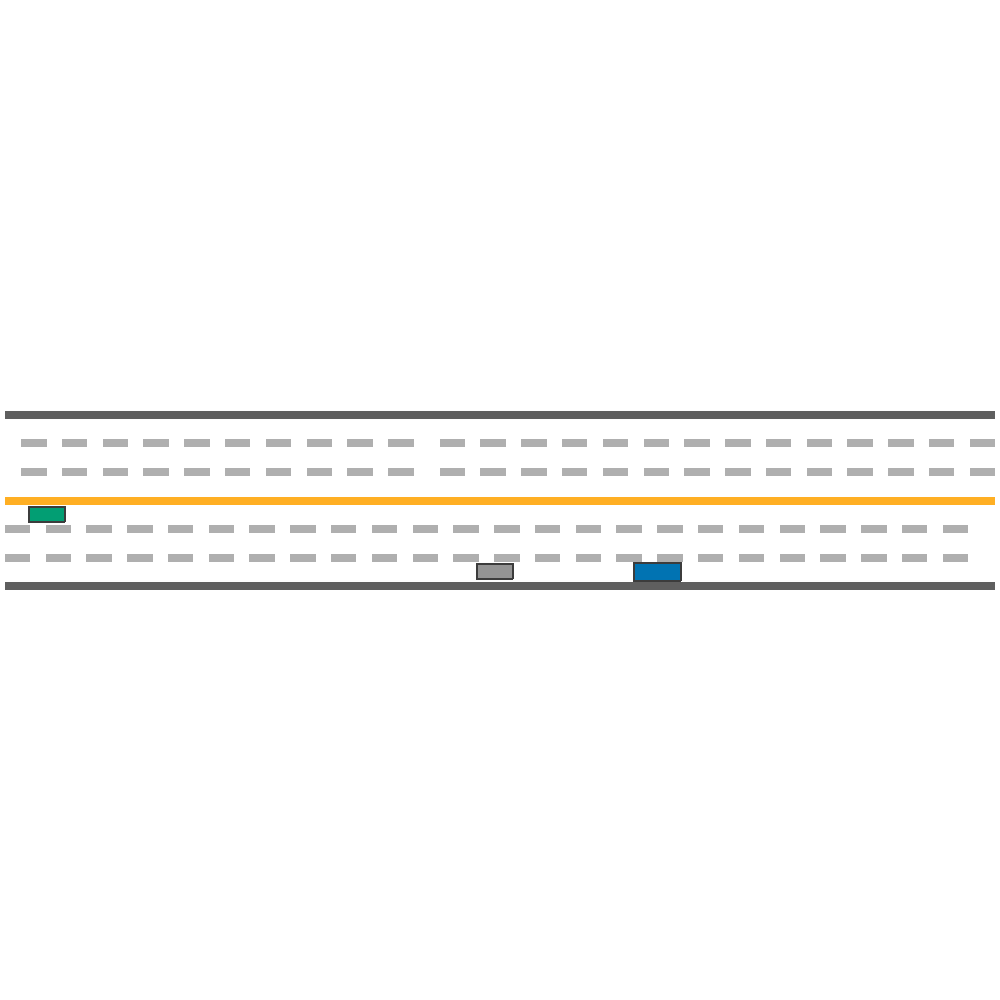

PG agent achieves 125.5814677761268 return in MetaDrive easy environment.


In [34]:
# Run this cell without modification

# Render the learned behavior
# NOTE: The learned agent is marked by green color.
eval_reward, eval_info = evaluate(
    policy=pg_trainer_wb_metadrive_easy.policy, 
    num_episodes=1, 
    env_name=pg_trainer_wb_metadrive_easy.env_name,
    render="topdown",  # Visualize the behaviors in top-down view
    verbose=True
)

frames = [pygame.surfarray.array3d(f).swapaxes(0, 1) for f in eval_info["frames"]]

animate(frames)

print("PG agent achieves {} return in MetaDrive easy environment.".format(eval_reward))

Text(0.5, 1.0, 'Policy Gradient in MetaDrive: Baseline matters!')

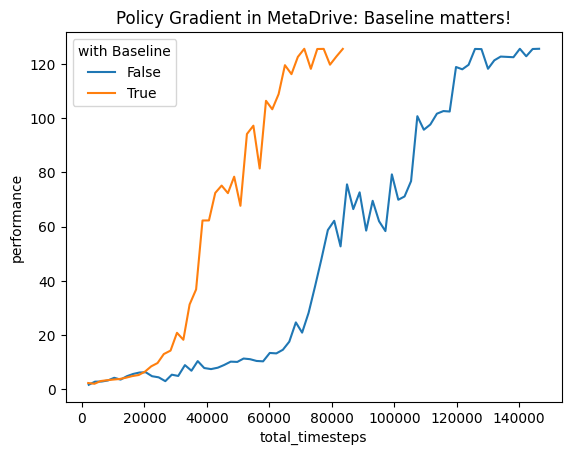

In [35]:
# Run this cell without modification

pg_trainer_wb_metadrive_easy_result_df = pd.DataFrame(pg_trainer_wb_metadrive_easy_result)
pg_trainer_wb_metadrive_easy_result_df["with Baseline"] = True


pg_trainer_metadrive_easy_result_df = pd.DataFrame(pg_trainer_metadrive_easy_result)
pg_trainer_metadrive_easy_result_df["with Baseline"] = False

ax = sns.lineplot(
    x="total_timesteps", 
    y="performance", 
    data=pd.concat([pg_trainer_wb_metadrive_easy_result_df, pg_trainer_metadrive_easy_result_df]).reset_index(), 
    hue="with Baseline",
)
ax.set_title("Policy Gradient in MetaDrive: Baseline matters!")

### Section 5.4: Run PG with baseline in MetaDrive-Hard

**Goal: Acheive episodic return > 50.**

**BONUS!!** **can be earned if you can improve the training performance by adjusting hyper-parameters and optimizing code. Improvement means achieving > 0.0 success rate. However, I can't promise that it is feasible to use PG with or without algorithm to solve this task.** Please creates a independent markdown cell to highlight your improvement.

In [ ]:
# Run this cell without modification

env_name = "MetaDrive-Tut-Hard-v0"

pg_trainer_wb_metadrive_hard, pg_trainer_wb_metadrive_hard_result = run(
    PolicyGradientWithBaselineTrainer, 
    dict(
        train_batch_size=4000,
        normalize_advantage=True,
        max_episode_length=1000,
        max_iteration=5000,
        evaluate_interval=10,
        evaluate_num_episodes=10,
        learning_rate=0.001,
        clip_norm=10.0,
        env_name=env_name
    ), 
    reward_threshold=120
)

pg_trainer_wb_metadrive_hard.save("pg_trainer_wb_metadrive_hard.pt")

In [ ]:
# Run this cell without modification

# Render the learned behavior
# NOTE: The learned agent is marked by green color.
eval_reward, eval_info = evaluate(
    policy=pg_trainer_wb_metadrive_hard.policy, 
    num_episodes=1, 
    env_name=pg_trainer_wb_metadrive_hard.env_name,
    render="topdown",  # Visualize the behaviors in top-down view
    verbose=True
)

frames = [pygame.surfarray.array3d(f).swapaxes(0, 1) for f in eval_info["frames"]]

animate(frames)

print("PG agent achieves {} return in MetaDrive hard environment.".format(eval_reward))

------

## Conclusion and Discussion

In this assignment, we learn how to build naive Q learning, Deep Q Network and Policy Gradient methods.

In the next markdown cell, you can write whatever you like. Like the suggestion on the course, the confusing problems in the assignments, and so on.

If you want to do more investigation, feel free to open new cells via `Esc + B` after the next cells and write codes in it, so that you can reuse some result in this notebook. Remember to write sufficient comments and documents to let others know what you are doing.

Following the submission instruction in the assignment to submit your assignment. Thank you!

------